In [37]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import baseline_classifier as bsclf
%matplotlib inline

# Table of content
* [1 The assignment](#Introduction)
* [2 The data](#TheData)
* [3 Loading the data](#LoadingTheData)
* [4 Exploratory data analysis](#ExploratoryDataAnalysis)
    * [4.1 How many bank entries do companies have?](#HowManyBankEntries)
    * [4.2 How many accounts do companies have?](#HowManyAccounts)
    * [4.3 How many bank entries are there per account?](#HowManyBankEntriesPerAccount)
    * [4.4 Summary of exploratory data analysis](#SummaryOfExploratory)
    * [4.5 Looking into a single company in more detail](#SingleCompanyExploratory) 
* [5 Building the baseline classifier](#BuildingTheBaselineClassifier) (Part 1)
* [6 Testing the baseline classifier](#TestingTheBaselineClassifier)
    * [6.1 Testing on a single company](#TestingTheBaselineClassifierOnSingle)
    * [6.2 Testing the classifier on each company](#TestingTheBaselineClassifierOnAll)
    * [6.3 Summary of the baseline classifier](#SummaryOfTheBaselineClassifier)
* [7 Taking advantage of the data across different companies](#TheSecondPart) (Part 2)
    * [7.1 Mapping text onto features](#MappingText)

# 1. The assignment<a id='Introduction'></a>
This is my solution to the hiring assignment e-conomics posed the candidates applying for a position as a Data Scientist on the machine learning team. The assignment is descibed in detail [here](https://github.com/e-conomic/hiring-assigments/tree/master/autosuggest/bankrec-assignment).

In short the assignment is to build a classifier that that can predict which account a given bank entry should be filed under. The assignment is divided into two parts. In the first part the candidate is asked to build and test a classifier __for each__ company. In the second part the candidate is asked to reflect on how one could build a classifier that works __for all__ companies. This would greatly increase the amount of training data and (perhaps) simply the process of classifying the bank entries.

# 2. The data<a id='TheData'></a>
The dataset consist of expenses from 100 random companies. For each all expenses that was booked in e-conomic (737017 bank entries in total) are provided. For each bank entry the following details are included as columns in the dataset:
* **CompanyId**: The identifyer of the company to help you slice and dice the data in the right way.
* **BankEntryDate (feature)**: The date of the financial transaction.
* **BankEntryText (feature)**: The text following along with the financial transaction. This is typically machine generated, but in case of manual transactions they may be manually written by a human.
* **BankEntryAmount (feature)**: The amount of the financial transaction. Expenses are negative, earnings are positive.
* **AccountNumber (target)**: The account number. The uniquely identifies an account, and can therefore be used as the target variable / the class that we want to predict.
* **AccountName**: The name of the account.
* **AccountTypeName**: The type of the account.

# 3. Loading and inspecting the data<a id='LoadingTheData'></a>

In [38]:
data = pd.read_csv('data/bank_expenses_obfuscated.csv')
print(data.shape)

(737017, 8)


We have 737017 entries.

Let's look at the first 5 rows of the dataframe.

In [39]:
print(data[0:5])

   Unnamed: 0    CompanyId BankEntryDate  \
0           0  int:a055470    2016-02-29   
1           1  int:a055470    2016-02-29   
2           2  int:a055470    2016-02-29   
3           3  int:a055470    2016-02-29   
4           4  int:a055470    2016-02-29   

                                     BankEntryText BankEntryAmount  \
0                          str:6cd08e4 int:49fed34         > -1000   
1                          str:6cd08e4 int:49fed34         > -1000   
2                                      str:38248d2          > -100   
3                                      str:38248d2          > -100   
4  str:c704d91 str:1b0ad3b str:2598b78 str:070dddb        > -10000   

   AccountName  AccountNumber  AccountTypeName  
0  str:1e82557           9900          Balance  
1  str:9ce853c           3115  Profit and Loss  
2  str:a9f0788           2240  Profit and Loss  
3  str:1e82557           9900          Balance  
4  str:a67d2b5           2270  Profit and Loss  


# 4 Exploratory data analysis<a id='ExploratoryDataAnalysis'></a>
The goal is to get a better understanding of the data before I build a simple classifier that can work as a baseline for more complicated classifiers.
## 4.1 How many bank entries do the companies have? <a id='HowManyBankEntries'></a>
Since the input to the classifier will be a bank entry, we should understand how many entries each company has. This way we can get an idea about how data intensive we can allow our classifiers to be. 

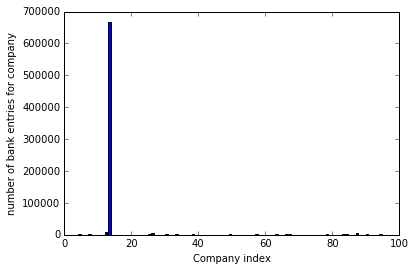

In [40]:
companies = data['CompanyId'].unique()

kk = 0
numBankEntries = np.zeros((100,1))
for company in companies:
    numBankEntriesTemp = data[data.CompanyId==company].count()[0]
    numBankEntries[kk] = numBankEntriesTemp
    kk += 1
    
plt.bar(range(0,100),numBankEntries)
plt.xlabel('Company index')
plt.ylabel('number of bank entries for company')

So by far the majority of bank entries are located with just a single company! This happens to be the 13th company in the list:

In [41]:
print(numBankEntries[13])

[ 667021.]


**So just one of the companies has about 90 of the entire dataset!**

It would be tempting to contine the analysis using this company, but it would be very representative of the average company.

Let have a closer look at some of the other companies: 

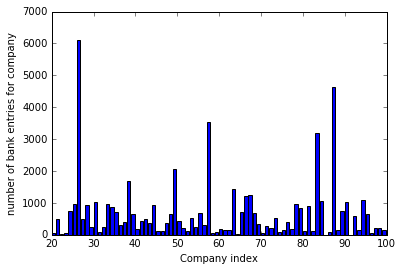

In [42]:
plt.bar(range(20,100),numBankEntries[20:100])
plt.xlabel('Company index')
plt.ylabel('number of bank entries for company')

It appears that it is much more common to have close to 1000 entries or less.

## 4.2 How many accounts do the companies have? <a id='HowManyAccounts'></a>
Since I am building a classifier for each company it is important to know how many accounts each company has. This is also important for the second part of the assigment, since builder a classifier that works for all companies might be difficult if the number of accounts varies a lot between companies.

Below I show the number of accounts for each company.

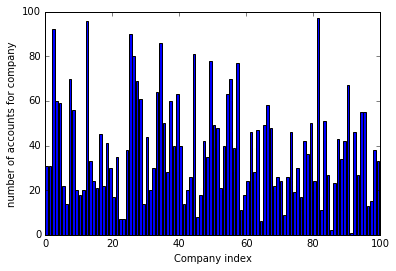

In [43]:
kk = 0
numAccounts = np.zeros((100,1))
for company in companies:
    company_data = data[data.CompanyId==company]
    numAccountsUnique = company_data['AccountNumber'].unique()
    numAccounts[kk] = numAccountsUnique.shape[0]
    kk += 1
    
plt.bar(range(0,100),numAccounts)
plt.xlabel('Company index')
plt.ylabel('number of accounts for company')

The number of accounts the companies have varies greatly.

A histogram of the number of accounts makes this point more clearly.

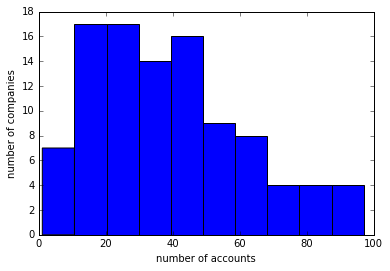

In [44]:
plt.hist(numAccounts)
plt.xlabel('number of accounts')
plt.ylabel('number of companies')

Most companies have between 10 and 50 accounts. 

## 4.3 Do companies with more bank entries also have more accounts?<a id='HowManyBankEntriesPerAccount'></a>
Ok. So the number of bank entries and accounts varies between companies. If companies with more accounts also have more bank entries, it might make classification easier. Let's have a look:

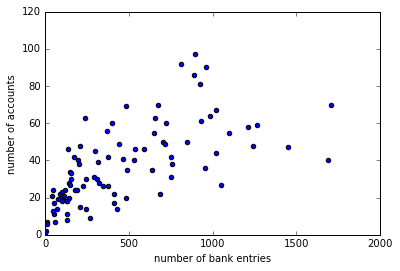

In [45]:
plt.scatter(numBankEntries,numAccounts)
plt.axis([0, 2000, 0, 120])
plt.xlabel('number of bank entries')
plt.ylabel('number of accounts')

So it does seem that there is a correlation between number of accounts and number of bank entries, but there is a lot of variability. 

How many bank entries are there per account on average?

[0, 100, 0, 20]

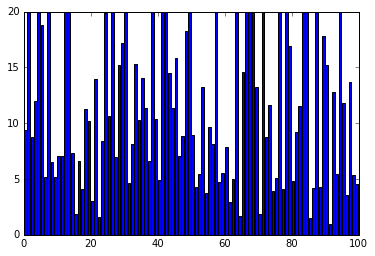

In [46]:
bankEntriesPerAccount = numBankEntries/numAccounts
plt.bar(range(0,100),bankEntriesPerAccount)
plt.axis([0, 100, 0, 20])

So it seems that quite a lot of the companies have fewer than 10 bank entries per account. This means that if we want to train a classifier per account per company, we had better use a classification model that does not need a lot of data to give good results.

## 4.4 Summary of exploratory data analysis<a id='SummaryOfExploratory'></a> 
* The data contains 100 companies, and 737017 bank entries. Of these **90% (667021/737017) are from a single company!** It is much more common for a company to have close to 1000 bank entries.
* Many companies have **between 10 and 50 accounts**.
* Many of the companies have **fewer than 10 bank entries per account**, on average.

## 4.5 Looking at a single company in more detail<a id='SingleCompanyExploratory'></a>
Above I look into the distribution of bank entries and bank accounts across the different companies. This gave a rough idea about what to expect from the data. However, since we are building a classifier for each company, understanding how the bank entries are distributed within a company is important.

I will start by looking a the data for a single company. I will use company **int:7cb070e**.

I am looking for the answer to the following questions:
* How many of the bank entry texts are unique?
* How are the bank entries distributed across the different accounts?

### 4.5.1 Selecting the data for the company ID int:7cb070e:

In [47]:
company_df = data[data.CompanyId=='int:7cb070e']
company_df[0:5]

,Unnamed: 0,CompanyId,BankEntryDate,BankEntryText,BankEntryAmount,AccountName,AccountNumber,AccountTypeName
1041,0,int:7cb070e,2016-06-29,str:0910abd str:325c669 str:acbadfb int:e14c8e7,> -10000,str:40b14b3,1310,Profit and Loss
1042,1,int:7cb070e,2016-06-29,str:4a5eaad str:640555d,> -10000,str:3a4a6a4,1321,Profit and Loss
1043,2,int:7cb070e,2016-06-28,str:1977f5c,> -100,str:d5770eb,2350,Profit and Loss
1044,3,int:7cb070e,2016-06-28,str:6086f71,> -10000,str:40b14b3,1310,Profit and Loss
1045,4,int:7cb070e,2016-06-27,str:2147693,> -10000,str:40b14b3,1310,Profit and Loss


### 4.5.2 How many bank entries does the company have?

In [48]:
company_df.shape

(808, 8)

So the company has a total of **808 bank entries**.

### 4.5.3 How many of the bank  entry texts are unique?<a id='HowManyBankEntriesAreUnique'></a>
The number of unique bank entry text is important because I would like to use this feature for the baseline classifier.

First I find all the unique **BankEntryText** for the Company

In [49]:
BankEntryText = company_df['BankEntryText'].unique()
numUniqueBankEntries = BankEntryText.shape[0]

Since the company has a total of **808 bank entries**, finding that **320 of them are unique** is not great. If they are unique it does not leave us much to train on.

### 4.5.4 How many accounts does the company have?

In [50]:
AccountNumber = company_df['AccountNumber'].unique()
numUniqueAccounts = AccountNumber.shape[0]
print(numUniqueAccounts)

92


The company has **92 accounts**

### 4.5.5 How are the bank entries distributed across the different accounts?

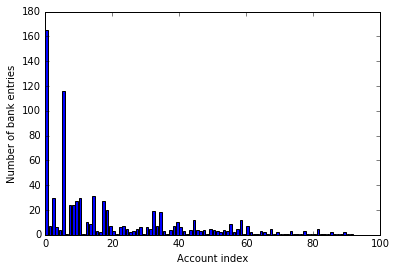

In [51]:
bakEntriesPerAccount = np.zeros(AccountNumber.shape)
kk=0
for item in AccountNumber:
    temp_bakEntriesPerAccount = company_df[company_df.AccountNumber==item].count()[0]
    bakEntriesPerAccount[kk] = temp_bakEntriesPerAccount
    kk += 1

plt.bar(range(0,AccountNumber.shape[0]),bakEntriesPerAccount)
plt.xlabel('Account index')
plt.ylabel('Number of bank entries')

It appears that most of the bank entries are filed under just a few of the accounts.

### 4.5.5 Summary of the exploratory analysis of a single company
In conclusion: We can expect the majority of the of the transactions to fall within a small number (~5 our of 31) of the accounts. This is usefull to know when building a classifier. It tells us that if we can build a classifier that correctly classifies to the most used accounts we should be able to get a decent accuracy of the classifier.

# 5 Building a baseline classifier<a id='BuildingTheBaselineClassifier'></a>
The exploratory analysis presented above suggests that a reasonable baseline would be to establish the frequency of each **speciic** bank entry going into a spefic account. That is, I want to calculate the following: Given a **BankEntryText** what is the probability that it is classified as **AccountNumber**. When I have **P** for each **AccountNumber**, I can sort by **P** and use that as my classifier whenever I encounter a **BankEntryText** that is allready in the training data. 

The classifier basically says: Put the bank entry where you usually put it. 

It will not be perfect and it only uses a single feature, but it is a good baseline. Any classification system I build should at least be able to beat this raw probabalistic appraoch.

For this I will continue to use the company with Conpanyid **int:a055470**

## 5.2 Etablishing the probabilities
I will use the following vectorization: I create a matrix containing the unique bank entries as rows and the bank accounts as columns. That is, it will be a matrix with the shape: __num unique banke entries x num bank account__.

Each unique bank entry will be a vector of length **number of bank accounts**.

In [52]:
myMatrix = np.zeros((numUniqueBankEntries,numUniqueAccounts))

kk = 0
for bankEntry in BankEntryText:
    test = company_df[company_df.BankEntryText == bankEntry]
    iteration = test['AccountNumber']
    
    for item in iteration:
        accountIndex = AccountNumber == item
        myMatrix[kk,:] = myMatrix[kk,:] + accountIndex
    
    kk += 1

So now we have established a matrix containing the information we want. For each **unique BankEntryText** it tell us which accounts these bank entries have been classified to. 

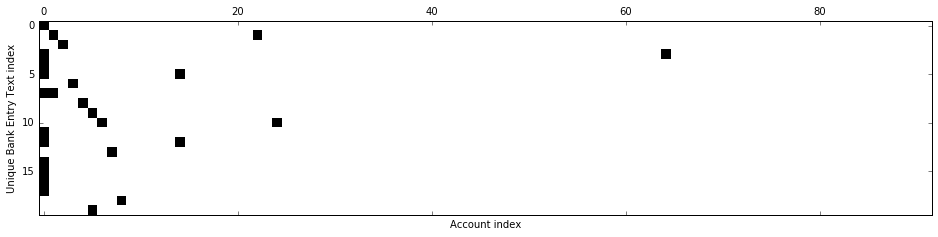

In [53]:
plt.matshow(1-myMatrix[0:20,:],
            cmap=plt.cm.gray, vmin=0, vmax=1)
plt.xlabel('Account index')
plt.ylabel('Unique Bank Entry Text index')

It seems that some of the **unique BankEntries** to different accounts. Let us have a closer look:

In [54]:
myMatrix[5,:]

array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

So some of the **unique BankEntries** do indeed go to different accounts.

The simplest version of the classifier takes the maximum of the elements for each row in the matrice and classifies the **unique BankEntry** as belonging to that account.

# 6. Testing the baseline classifier <a id='TestingTheBaselineClassifier'></a> 
## 6.1 Testing on a single company <a id='TestingTheBaselineClassifierOnSingle'></a>

In [55]:
# Divide the dataset into 80% train set and 20% test set
percentTrainSize = 0.8
trainSize = int(round(percentTrainSize*company_df.shape[0]))
testSize = int(company_df.shape[0]-trainSize)

train_df = company_df.tail(trainSize)
test_df = company_df.head(testSize)

# Build the matrice on the train set
trainMatrix = np.zeros((numUniqueBankEntries,numUniqueAccounts))
kk = 0
for bankEntry in BankEntryText:
    temp_df = train_df[train_df.BankEntryText == bankEntry]
    iteration = temp_df['AccountNumber']
    for item in iteration:
        accountIndex = AccountNumber == item
        trainMatrix[kk,:] = trainMatrix[kk,:] + accountIndex
    kk += 1
    
# Find the maximal element in the matrice and save a dictionary that contains BankEntry string and Account number
indices = np.zeros(len(trainMatrix))
for row in range(0,len(trainMatrix)):
    index = np.where(trainMatrix[row,:]==max(trainMatrix[row,:]))
    indices[row] = index[0][0]
    #trainMatrix[row,index][0][0]

# Making the dictionary
kk=0
bankEntryTextToAccountNumber = {}
for bankEntry in BankEntryText:
    bankEntryTextToAccountNumber[bankEntry] = AccountNumber[indices[kk]]
    kk += 1

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [56]:
y_test = np.zeros((testSize,1))
kk = 0
for account in test_df['AccountNumber']:
    y_test[kk] = account
    kk += 1
    
kk = 0
y_predict = np.zeros((testSize,1))
for text in test_df['BankEntryText']:
    y_predict[kk] = bankEntryTextToAccountNumber[text]
    kk += 1

numCorrect = float(sum(y_predict==y_test))
accuracy = numCorrect/testSize

print('Number of test cases is: ' + str(testSize))
print('number of correct predictions is: ' + str(numCorrect))
print('The accuracy is: ' + str(accuracy))


Number of test cases is: 162
number of correct predictions is: 100.0
The accuracy is: 0.617283950617


For a base line that isn't bad

## 6.2 Testing the classifier on each company<a id='TestingTheBaselineClassifierOnAll'></a>
Above we say that for the specific company the baseline classifier had an accuracy of 60%. Thats quite ok, but we have allready seen that the number of accounts and bank entries varies a lot between the companies. So how does the baseline do on **every single company?**

Below I run the baseline classifier on every company using 80% of the data is training data. The 80% are the oldest 80 % of the data.

In [57]:
reload(bsclf)

all_test_sizes = np.zeros((100,1))
all_num_correct = np.zeros((100,1))
all_accuracies = np.zeros((100,1))
kk=0
for company in companies:
    company_df = data[data.CompanyId == company]
    train_size, test_size, num_correct, accuracy = bsclf.baseline_classifier(company_df)
    
    all_test_sizes[kk] = test_size
    all_num_correct[kk] = num_correct
    all_accuracies[kk] = accuracy
    
    kk += 1

baseline_classifier.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Looking at how the accuracy changes with test size:

The average accuracy is: [ 0.42753461]


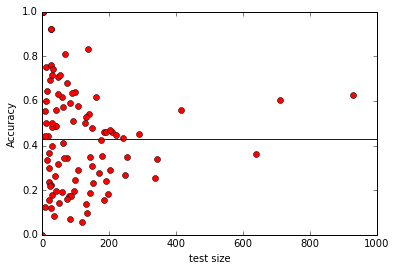

In [58]:
avgAccuracy = sum(allAccuracies)/len(allAccuracies)

plt.plot(allTestSizes,allAccuracies,'or')
plt.plot([0, 1000],[avgAccuracy, avgAccuracy],'-b')
plt.axis([0, 1000, 0, 1])
plt.xlabel('test size')
plt.ylabel('Accuracy')

print('The average accuracy is: ' + str(avgAccuracy))

There is a lot of variability in the accuracy! This is even true for the companies with more than 100 bank entries in the test set. However, above 200 bank entries in the test set the baseline classifier appears to deliver more consistent results. The average accuracy of 42% is not good, but it serves as a fine baseline.

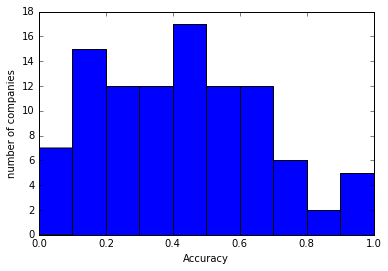

In [59]:
plt.hist(allAccuracies)
plt.ylabel('number of companies')
plt.xlabel('Accuracy')

## 6.3 Summary of the baseline classifier<a id='SummaryOfTheBaselineClassifier'></a>

# 7 The second part<a id='TheSecondPart'></a>
Making a classifier that can take advantage of data across different companies. The allows us to avoid the __cold start__ problem.

## 7.1 Mapping text onto features<a id='MappingText'></a>
One way to get around this is to build a classifier that is based on the name of the account name rather than the speficic account id. In this way, if a company open up a new account with a title that is allready known we would be able to use the information from other companies. 